# Imports/Set up

In [ ]:
!pip install idx2numpy
!pip install python_mnist
from mnist import MNIST
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data)
train_label = np.array(train_label)
test_data = np.array(test_data)
test_label = np.array(test_label)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [ ]:
#getting specific data and standardizing
substdata = np.where((train_label == 4) |(train_label == 7) | (train_label == 8)) 
sublabels = train_label[substdata]

# PCA (1.A)

In [ ]:
stdata = train_data[substdata] - np.mean(train_data[substdata] , axis=0)
covar = np.cov(stdata.T)
lambd, vec = eigh(covar, eigvals=(782,783))# num dimensions = [b,a]
pca = np.matmul(train_data[substdata],vec)

In [ ]:
#Takes much longer to run than below but produces a smoother graph
#disterr = []
#for i in range(1,len(stdata[0])):
  #eigval, eigvec = eigh(covar, eigvals=(i, len(vec)-1))
  #disterr.append( np.linalg.norm( stdata - (np.dot(np.dot(eigvec.T, stdata.T).T, eigvec.T))  ))
#disterr.reverse()
#plt.plot(range(1,len(disterr)+1),disterr)
#plt.ylabel('Distortion error')
#plt.xlabel('num dimensions')
#plt.show()

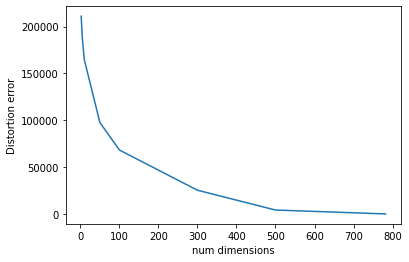

In [ ]:
m = [2,5,10,50,100,300,500,782]#num dimensions 
disterr=[]
for i in m:
  dval, dvec = eigh(covar, eigvals=(len(vec)-i,len(vec)-1))
  disterr.append( np.linalg.norm( stdata - (np.dot(np.dot(dvec.T, stdata.T).T, dvec.T))  ))
plt.plot(m,disterr)
plt.ylabel('Distortion error')
plt.xlabel('num dimensions')
plt.show()

[ 3.40834255e+05+0.00000000e+00j  2.78992989e+05+0.00000000e+00j
  2.09727443e+05+0.00000000e+00j  1.77455702e+05+0.00000000e+00j
  1.36479581e+05+0.00000000e+00j  1.16082361e+05+0.00000000e+00j
  9.06093260e+04+0.00000000e+00j  8.38706798e+04+0.00000000e+00j
  8.14621805e+04+0.00000000e+00j  7.43007286e+04+0.00000000e+00j
  6.30083855e+04+0.00000000e+00j  5.62079805e+04+0.00000000e+00j
  5.11813007e+04+0.00000000e+00j  4.69719412e+04+0.00000000e+00j
  4.46330977e+04+0.00000000e+00j  4.14858511e+04+0.00000000e+00j
  4.05783429e+04+0.00000000e+00j  3.63358722e+04+0.00000000e+00j
  3.42679160e+04+0.00000000e+00j  3.26014870e+04+0.00000000e+00j
  2.97981556e+04+0.00000000e+00j  2.92871367e+04+0.00000000e+00j
  2.79158153e+04+0.00000000e+00j  2.65507230e+04+0.00000000e+00j
  2.54096209e+04+0.00000000e+00j  2.46011995e+04+0.00000000e+00j
  2.35439704e+04+0.00000000e+00j  2.23848024e+04+0.00000000e+00j
  2.12472514e+04+0.00000000e+00j  1.98481872e+04+0.00000000e+00j
  1.91695858e+04+0.000000

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


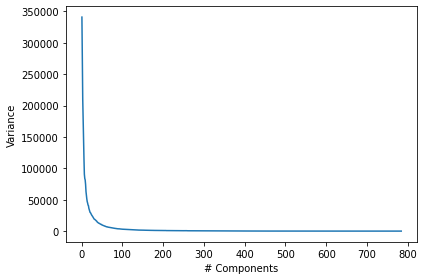

In [ ]:
#VARIANCE
cnt = 0
eva, eve = np.linalg.eig(covar)
print(eva)
var = [(i/np.sum(eva)) for i in (eva)]
sumeig = np.sum(var)
#print(len(var))
#print(sumeig)
plt.plot(range(1,len(eva)+1), eva)
variance = 0
for i in eva:
  cnt+=1
  variance +=i
  if variance/np.sum(eva) >=0.98:
    print("Variance is >= 0.98 when at least " + str(cnt) + " dimensions are used")
    break
#plt.hlines(0.98, 300,500)
#plt.axvline(408,0.8,1)
plt.ylabel('Variance')
plt.xlabel('# Components')
plt.tight_layout()
plt.show()

# LDA (1.B)

In [ ]:
#LDA
dat = train_data[np.where( (train_label == 4) |(train_label == 7) | (train_label == 8) )]
overmean = np.mean(dat, axis=0)
Sw = np.zeros((train_data.shape[1],train_data.shape[1]))
Sb = np.zeros((train_data.shape[1],train_data.shape[1]))
for x in [4,7,8]:
  data = train_data[train_label == x ]
  mean_vec = np.mean(data, axis=0)
  print(np.mean(mean_vec))
  Sw += ((data - mean_vec).T.dot((data-mean_vec)))/data.shape[0]
  md = (mean_vec - overmean).reshape(data.shape[1],1)
  Sb += data.shape[0] * md.dot(md.T)

30.94822568277568
29.204562926527355
38.289775382892856


In [ ]:
#regular inverse would not work because it is a singular matrix
Amat = np.linalg.pinv(Sw).dot(Sb)
eigval, eigvec = eigh(Amat, eigvals=(782,783))
LDA = dat.dot(eigvec)

# TSNE + Graphs (1.C)

In [ ]:
#prepping for TSNE graph
tsdata = train_data[substdata] - np.mean(train_data[substdata] , axis=0)
tslabels = sublabels
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tsdata)

In [ ]:
tsne_data = np.vstack((tsne_data.T, tslabels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('1st_principal', '2nd_principal', 'labels'))
sn.FacetGrid(tsne_df, hue='labels', height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

In [ ]:
pcdata = np.vstack((pca.T,sublabels)).T
print(pcdata.shape)
pca_df = pd.DataFrame(data=pcdata,columns=('1st_principal','2nd_principal','labels'))
sn.FacetGrid(pca_df,hue='labels',height=6).map(plt.scatter,'1st_principal','2nd_principal').add_legend()
plt.show()

In [ ]:
lddata = np.vstack((LDA.T,sublabels)).T
print(lddata.shape)
lda_df = pd.DataFrame(data=lddata,columns=('1st_principal','2nd_principal','labels'))
sn.FacetGrid(lda_df,hue='labels',height=6).map(plt.scatter,'1st_principal','2nd_principal').add_legend()
plt.show()

# 2.B Gradients

# Loading data

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(return_X_y=True)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.14)
print(x_train.shape)
print(x_test.shape)
bweights = np.random.rand(x_test.shape[1])

(435, 13)
(71, 13)


# Linear Regression

In [ ]:
#w for linear regression
#lweights = np.random.rand(x_test.shape[1])
lweights = bweights
i=0
errlist = [1e10]
cont = True
while cont:
  rate = 0.00001
  #randomizing batches
  randord = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
  randx = x_train[randord]
  randy = y_train[randord]
  #batch size of 29 and 15 batches
  #stored as [[x1,y1],[x2,y2]...]
  for xbatch,ybatch in [(randx[i:i+29], randy[i:i+29]) for i in range(0,x_train.shape[0],29)]:
    if cont:
      err = xbatch.dot(lweights)-ybatch
      errlist.append( np.mean(err**2) )
      grad = xbatch.T.dot(err)
      lweights -= (rate/x_test.shape[0])*(grad)
      rate /= 1.1
    if abs(errlist[-2]-errlist[-1]) < 1e-4:
       cont = False
  i+=1
#print(i)

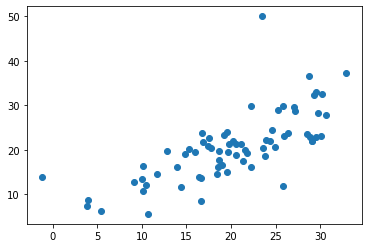

MSE:= 457.8903748009777
RMSE:= 21.398373181178464
[-0.07161467  0.07586875  0.04194665  0.34394     0.11971476  1.90632125
  0.10433308  0.43592028  0.14332644 -0.00929572  0.20442346  0.02117512
 -0.77158167]
20.640845070422543
20.123375274978834


In [ ]:
lpred = lweights.dot(x_test.T)
plt.scatter(lpred, y_test)
plt.show()
mse = np.mean((lpred**2))
rmse = np.sqrt(mse)
print("MSE:= " + str(mse))
print("RMSE:= " + str(rmse))
print(lweights)
print(np.mean(y_test))
print(np.mean(lpred))

# Ridge Regression

In [ ]:
#w for linear regression
#rweights = np.random.rand(x_test.shape[1])
rweights = bweights
i=0
errlist = [1e10]
cont = True
#idmat = np.ones(x_test.shape[1])
lambdashift = 0.8
while cont:
  rate = 0.00001
  #randomizing batches
  randord = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
  randx = x_train[randord]
  randy = y_train[randord]
  #batch size of 29 and 15 batches
  #stored as [[x1,y1],[x2,y2]...]
  for xbatch,ybatch in [(randx[i:i+29], randy[i:i+29]) for i in range(0,x_train.shape[0],29)]:
    if cont:
      err = xbatch.dot(rweights)-ybatch
      errlist.append( np.mean(err**2) )
      grad = xbatch.T.dot(err) + lambdashift*rweights 
      rweights -= (rate/x_test.shape[0])*(grad)
      rate /= 1.1
      #print(errlist[-2]-errlist[-1])
    if abs(errlist[-2]-errlist[-1]) < 1e-4:
       cont = False
  i+=1
print(i)

6196


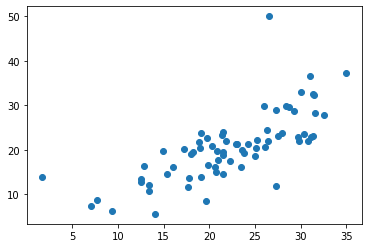

MSE:= 38435.26276995863
RMSE:= 23.266751581480964
[-0.07373198  0.0758086   0.04062379  0.38235303  0.14307347  2.44732979
  0.08788587  0.17545989  0.14479614 -0.00606773  0.17719083  0.02010423
 -0.73417154]
20.640845070422543
22.252400947114708


In [ ]:
#print(i)
rpred = rweights.dot(x_test.T)
plt.scatter(rpred, y_test)
plt.show()
mse = np.sum((rpred**2))
rmse = np.sqrt(mse/y_test.shape[0])
print("MSE:= " + str(mse))
print("RMSE:= " + str(rmse))
print(rweights)
print(np.mean(y_test))
print(np.mean(rpred))
#print(pred)
#print(y_test)

# LASSO

In [ ]:
#w for linear regression
#laweights = np.random.rand(x_test.shape[1])
laweights = bweights
i=0
errlist = [1e10]
cont = True
#idmat = np.ones(x_test.shape[1])
lambdashift = 0.8
while cont:
  rate = 0.00001
  #randomizing batches
  randord = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
  randx = x_train[randord]
  randy = y_train[randord]
  #batch size of 29 and 15 batches
  #stored as [[x1,y1],[x2,y2]...]
  for xbatch,ybatch in [(randx[i:i+29], randy[i:i+29]) for i in range(0,x_train.shape[0],29)]:
    if cont:
      err = xbatch.dot(laweights)-ybatch
      errlist.append( np.mean(err**2) )
      grad = xbatch.T.dot(err) + lambdashift*np.sum(laweights) 
      laweights -= (rate/x_test.shape[0])*(grad)
      rate /= 1.1
      #print(errlist[-2]-errlist[-1])
    if abs(errlist[-2]-errlist[-1]) < 1e-4:
       cont = False
  i+=1
print(i)

6899


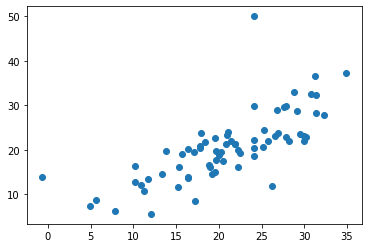

MSE:= 491.88695980525046
RMSE:= 22.178524743662514
[-0.07787343  0.07604301  0.02224436  0.40508172  0.14625413  2.95390434
  0.07160024 -0.07526136  0.13845877 -0.00954736  0.11519373  0.02019319
 -0.69360567]
20.640845070422543
20.96668368972393


In [ ]:
lapred = laweights.dot(x_test.T)
plt.scatter(lapred, y_test)
plt.show()
mse = np.mean(np.abs(lapred)**2)
rmse = np.sqrt(mse)
print("MSE:= " + str(mse))
print("RMSE:= " + str(rmse))
print(laweights)
print(np.mean(y_test))
print(np.mean(lapred))

# Regression Comparisons

Linear regression: 
MSE:= 457.8903748009777
RMSE:= 21.398373181178464
Actual y median:= 20.4
Predicted y median:= 20.183059758007175
[-0.07787343  0.07604301  0.02224436  0.40508172  0.14625413  2.95390434
  0.07160024 -0.07526136  0.13845877 -0.00954736  0.11519373  0.02019319
 -0.69360567]


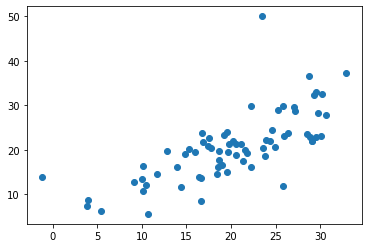



Ridge regression: 
MSE:= 541.3417291543469
RMSE:= 23.266751581480964
Actual y median:= 20.4
Predicted y median:= 21.81436713450745
[-0.07787343  0.07604301  0.02224436  0.40508172  0.14625413  2.95390434
  0.07160024 -0.07526136  0.13845877 -0.00954736  0.11519373  0.02019319
 -0.69360567]


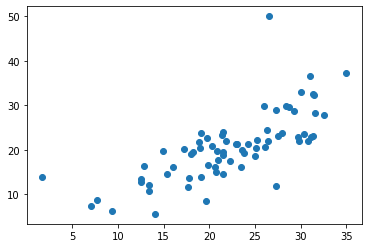



LASSO: 
MSE:= 491.88695980525046
RMSE:= 22.178524743662514
Actual y median:= 20.4
Predicted y median:= 21.01886366627774
[-0.07787343  0.07604301  0.02224436  0.40508172  0.14625413  2.95390434
  0.07160024 -0.07526136  0.13845877 -0.00954736  0.11519373  0.02019319
 -0.69360567]


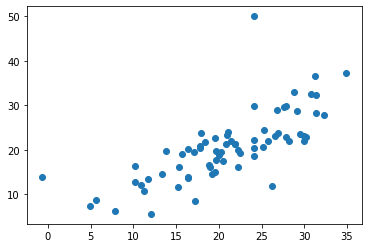

In [ ]:
print("Linear regression: ")
mse = np.mean(np.abs(lpred)**2)
rmse = np.sqrt(mse)
print("MSE:= " + str(mse))
print("RMSE:= " + str(rmse))
print("Actual y median:= " + str(np.median(y_test)))
print("Predicted y median:= " + str(np.median(lpred)))
print(lweights)
plt.scatter(lpred, y_test)
plt.show()
print("\n\nRidge regression: ")
mse = np.mean(np.abs(rpred)**2)
rmse = np.sqrt(mse)
print("MSE:= " + str(mse))
print("RMSE:= " + str(rmse))
print("Actual y median:= " + str(np.median(y_test)))
print("Predicted y median:= " + str(np.median(rpred)))
print(rweights)
plt.scatter(rpred, y_test)
plt.show()
print("\n\nLASSO: ")
mse = np.mean(np.abs(lapred)**2)
rmse = np.sqrt(mse)
print("MSE:= " + str(mse))
print("RMSE:= " + str(rmse))
print("Actual y median:= " + str(np.median(y_test)))
print("Predicted y median:= " + str(np.median(lapred)))
print(laweights)
plt.scatter(lapred, y_test)
plt.show()